### To Do
 - Sort issue with estimating the correction trials
 - Use pandas
 - 

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import plotly as pty
import plotly.express as px
import numpy as np
import scipy.stats
import sys, os, re, csv
#import seaborn
import pandas as pd
import loadBehavioralData as ld
import mpld3
from pandas.io.json import json_normalize

%matplotlib inline
#plt.style.available # List of available plot styles
mpl.style.use('seaborn-colorblind')



# Computing
## Select animal

In [7]:
animalName = "Gouda"
dataPath = "C:\\Users\\Quentin Gaucher\\data\\ENS behavior\\data"
path = os.path.join(dataPath,animalName)
figSize = (10,5)

## Load files and compute trials

In [8]:
fileList = (os.listdir(path))
# remove ignored files (merged leftover)
fileList = [f for f in fileList if len(re.findall("_ignore", f)) == 0]
sessionNB = list()
sessionDate = list()
sessionSplit = list()
for files in fileList:
    sNB = int(re.findall('session([0-9]{1,3})',files)[0])
    if sNB > 0:
        sessionNB.append(sNB)
        sessionDate.append(re.findall('_([0-9]{6})',files)[0])
        sessionSplit.append(sessionDate[-1] + '_' + str(sessionNB[-1]))
#fileList = fileList(np.argsort(sessionNB))
fileList[:] = [fileList[i] for i in np.argsort(sessionNB)]
sessionDate[:] = [sessionDate[i] for i in np.argsort(sessionNB)]
sessionSplit[:] = [sessionSplit[i] for i in np.argsort(sessionNB)]
sessionNB.sort()

In [9]:
#print(sessionDate[0])

In [10]:
allTrials = list()
allGoodTrials = list()
for files in fileList:
    #print(files)
    filePath = os.path.join(path,files)
    dataObj = ld.dataManage(filePath,True)
    Trials = dataObj.getTrials()
    goodTrials = dataObj.getGoodTrials()
    allTrials.append(Trials)
    allGoodTrials.append(goodTrials)

In [ ]:
allTrialsDF = ld.trialDataFrame(allGoodTrials,sessionDate)
allTrialsDF.to_pickle(os.path.join(dataPath,animalName + '_allTrialsDF'))


In [175]:
from scipy.special import ndtri
ndtri(0.8)

0.8416212335729143

In [22]:
# allTrialsDF['aborted']
idx = (allTrialsDF['aborted'] == False) & (allTrialsDF['correction trial'] == False)
allTrialsDF_filt = allTrialsDF[idx]

groupedStim = allTrialsDF_filt.groupby(['session nb','stimulus'])

grouped = allTrialsDF_filt.groupby(['session nb'])
grouped_unfilt = allTrialsDF.groupby(['session nb'])

BadTrialCount = grouped_unfilt['correction trial','aborted'].sum().astype(int)

leftPokes = grouped.apply(lambda x: (((x['stim'] == 0) & (x['hit'] == True)) | ((x['stim'] == 1) & (x['hit'] == False))).sum())

missCount = grouped['hit'].agg(lambda x: (x==False).sum())
missCount = missCount.rename(columns={"hit": "miss"})
hitCount = grouped['hit'].agg(lambda x: (x==True).sum())

hitCountT = grouped.apply(lambda x: pd.Series((x['stim'] == 0) & (x['hit'] == True)).sum())
hitCountNT = grouped.apply(lambda x: pd.Series((x['stim'] == 1) & (x['hit'] == True)).sum())
missCountT = grouped.apply(lambda x: pd.Series((x['stim'] == 0) & (x['hit'] == False)).sum())
missCountNT = grouped.apply(lambda x: pd.Series((x['stim'] == 1) & (x['hit'] == False)).sum())

sessionDF = pd.concat([hitCount, missCount, hitCountT, hitCountNT, missCountT, missCountNT,BadTrialCount,leftPokes],axis=1)
sessionDF = sessionDF.rename(columns={'hit': 'hit', 0: 'miss', 1: 'hitTarget', 2: 'hitNonTarget', 3: 'missTarget', 4: 'missNonTarget', 5: 'NLeftPokes'})
sessionDF['NTrials'] = sessionDF['hit'] + sessionDF['miss']
sessionDF['hitRate'] = round(sessionDF['hit'] / sessionDF['NTrials'] * 100,2)
sessionDF['hitRateTarget'] = round(sessionDF['hitTarget'] / (sessionDF['hitTarget'] + sessionDF['missTarget']) * 100,2)
sessionDF['hitRateNonTarget'] = round(sessionDF['hitNonTarget'] / (sessionDF['hitNonTarget'] + sessionDF['missNonTarget']) * 100,2)

#grouped = allTrialsDF.groupby(["session nb"])
#hitCount = grouped['hit'].value_counts()
#hitCount = allTrialsDF_filt[allTrialsDF_filt.hit == True].count()

In [92]:
a = groupedStim['hit'].value_counts()
# a.loc[(40,'solicit_003')]
a_filt = a[a.index.get_level_values('stimulus') == 'solicit_005']
a_filt_hit = a_filt[a_filt.index.get_level_values('hit') == True]
a_filt_miss = a_filt[a_filt.index.get_level_values('hit') == False]
# a_filt_hit.reset_index(drop = True, inplace=True)
# a_filt_miss.reset_index(drop = True, inplace=True)
a_filt.agg(sum)

TypeError: 'int' object is not iterable

In [155]:
a = groupedStim['hit'].value_counts()
a_filt = a.xs('solicit_005', level='stimulus')
b = a_filt.xs(True, level = 'hit')
c = a_filt.xs(False, level = 'hit')
d = pd.concat([b,c], axis=1).fillna(0)
d.columns = ['hit', 'miss']
d['hitRate'] = d['hit'] / (d['hit'] + d['miss'])


In [172]:
stimNames = a.index.get_level_values('stimulus').unique().tolist()
stimNames
#fileList[:] = [fileList[i] for i in np.argsort(sessionNB)]
tList = [i for i in stimNames if 'solicit_' in i]
# 'solicit' in any(stimNames)
tList

['solicit_005', 'solicit_003', 'solicit_005CoTr', 'solicit_003CoTr']

In [300]:
pty.plot(sessionDF,kind='line',y = ['hitRate', 'hitRateTarget', 'hitRateNonTarget'])


In [317]:
y = round(sessionDF['NLeftPokes'] / sessionDF['NTrials'] * 100,2)
fig = pty.plot(y,kind='line',labels = {'value': r'% response left'})
fig.add_hline(y=50)

In [301]:
px.bar(sessionDF, y=["hit","miss",'correction trial','aborted'], title="Trial types",labels={"value": "N trials"})

In [168]:
sessionDF.head(10)

hit  miss  NTrials  hitRate
session nb                             
0           107    29      136    78.68
1            76    40      116    65.52
2            91    34      125    72.80
3            27    17       44    61.36
4             0     2        2     0.00
5            83    41      124    66.94
6            43    27       70    61.43
7            33    29       62    53.23
8            86    43      129    66.67
9            65    46      111    58.56

# Plots
## Delay before response

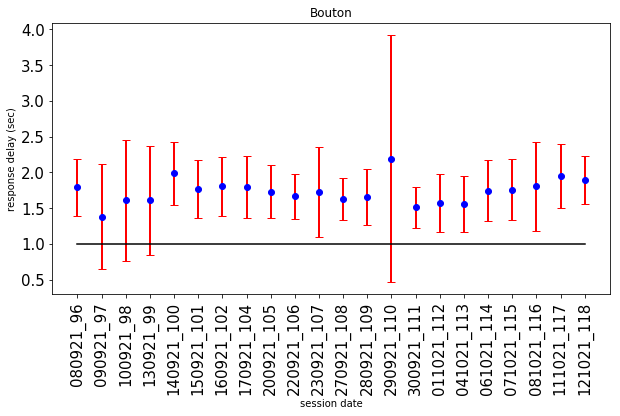

In [14]:

plt.figure(figsize=figSize)
plt.errorbar(sessionSplit,meanDelay,yerr=errDelay,fmt='o',ecolor='r',color='b',elinewidth=2,capsize=4)
plt.plot(sessionSplit,[1]*len(sessionSplit),color='k')
plt.xlabel('session date')
plt.ylabel('response delay (sec)')
plt.title(animalName)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## proportion of aborted trials

No handles with labels found to put in legend.


(array([  0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 7 Text yticklabel objects>)

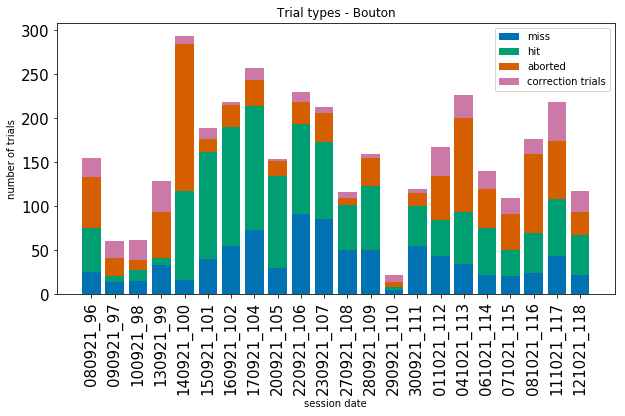

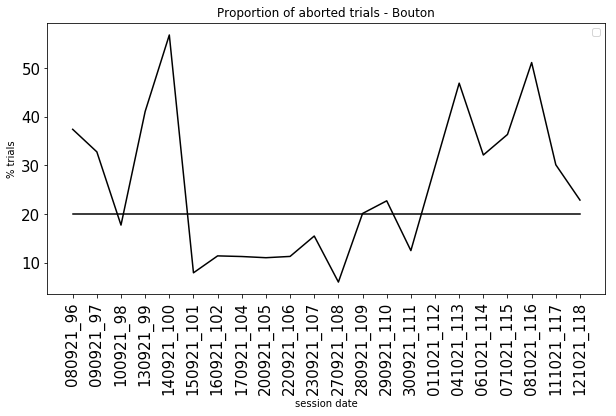

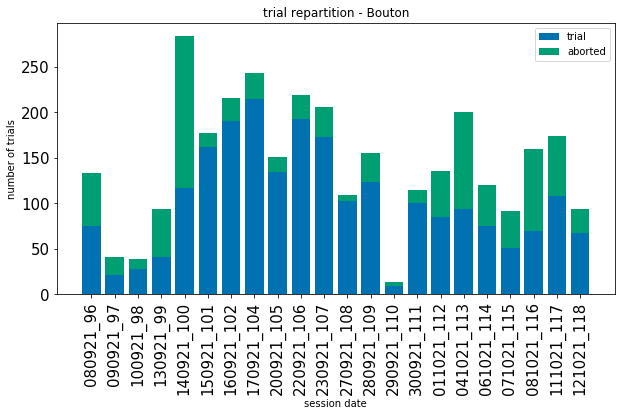

In [15]:
# stacked bars with number of hit, miss, aborted trials, correction trials
trialLength = list()
nAborted = list()
nCorrection = list()
hit = list()
miss = list()
Weird = list()

for trials in allGoodTrials:
    #trialLength.append(len(trials))
    #a = [(i['gotReward']) for i in trials]
    nAb = 0
    nCo = 0
    nHit = 0
    nMiss = 0
    nWeird = 0
    for trial in trials:
        if trial['aborted']:
            nAb += 1
        elif trial['correction trial']:
            nCo += 1
        elif trial['hit']:
            nHit = nHit + 1
        elif not trial['hit']:
            nMiss = nMiss + 1
        else:
            nWeird += 1

    hit.append(nHit)
    miss.append(nMiss)
    trialLength.append(len(trials))
    nAborted.append(nAb)
    nCorrection.append(nCo)
    Weird.append(nWeird)

hit = np.array(hit)
miss = np.array(miss)
trialLength = np.array(trialLength)
nAborted = np.array(nAborted)
nCorrection = np.array(nCorrection)
Weird = np.array(Weird)

plt.figure(figsize=figSize)
plt.bar(sessionSplit,miss,label="miss")
plt.bar(sessionSplit,hit,bottom = miss,label="hit")
plt.bar(sessionSplit,nAborted,bottom = miss + hit, label="aborted")
plt.bar(sessionSplit,nCorrection,bottom = hit + miss + nAborted,label="correction trials")
plt.legend()
plt.xlabel('session date')
plt.ylabel('number of trials')
plt.title("Trial types" + " - " + animalName)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)

abortedProp = (nAborted / (hit + miss + nAborted + nCorrection)) * 100
plt.figure(figsize=figSize)
plt.plot(sessionSplit,abortedProp,color='k')
plt.plot(sessionSplit,[20]*len(sessionSplit),color='k')
plt.legend()
plt.xlabel('session date')
plt.ylabel('% trials')
plt.title("Proportion of aborted trials" + " - " + animalName)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)

plt.figure(figsize=figSize)
plt.bar(sessionSplit,hit + miss,label="trial")
plt.bar(sessionSplit,nAborted,bottom = miss + hit, label="aborted")
plt.legend()
plt.xlabel('session date')
plt.ylabel('number of trials')
plt.title("trial repartition" + " - " + animalName)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)

In [16]:
# nTrials = hit + miss + nAborted + nCorrection
# for i,tr in enumerate(sessionSplit):
#     print(tr + ' - ' + str(nTrials[i]))

## Percent correct (hit rate / false alarm)

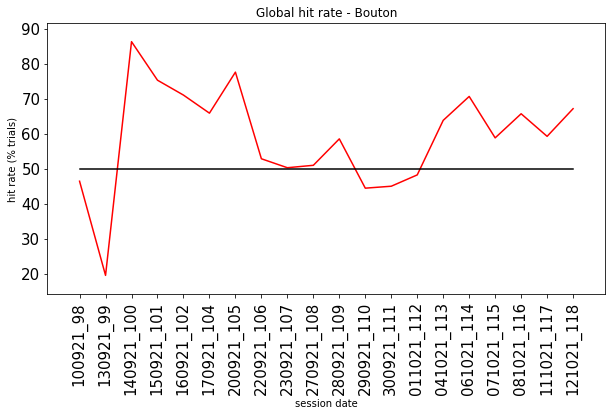

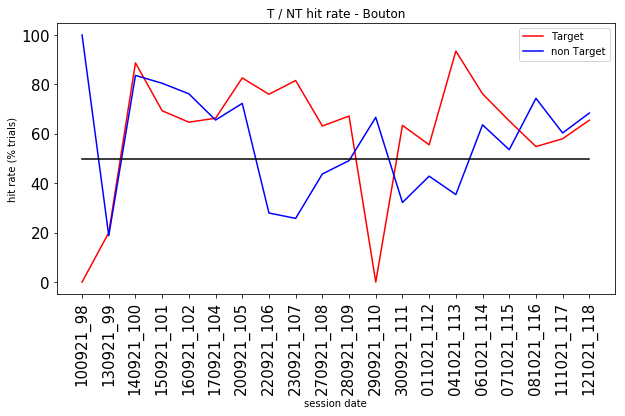

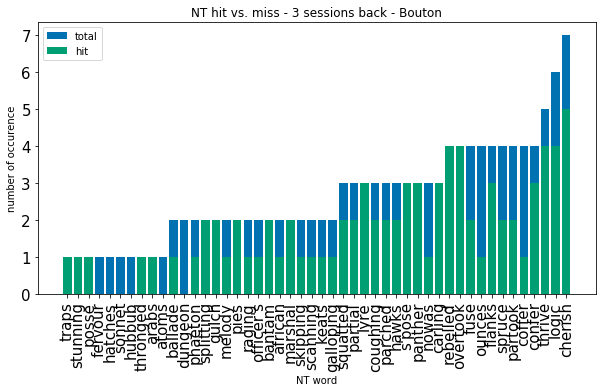

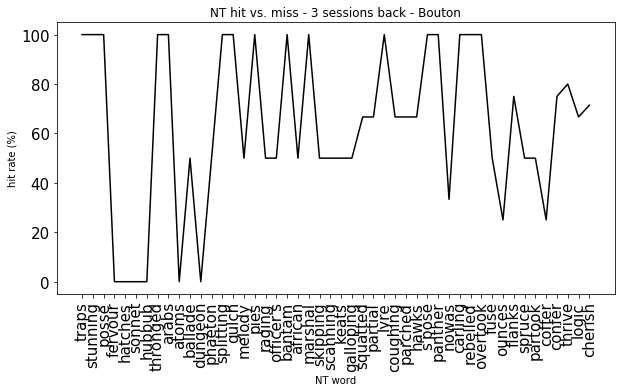

In [17]:


x = sessionSplit[2:]

# Global hit Rate
y = hitRate[2:]
# fig = plt.figure(figsize=figSize)
fig, ax = plt.subplots(figsize=figSize)
graph = plt.plot(x,y,color='r')
#plt.plot(sessionSplit,missRate,color='b')
plt.plot(x,[50]*len(x),color='k')
plt.xlabel('session date')
plt.ylabel('hit rate (% trials)')
plt.title('Global hit rate - ' + animalName)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)

scatter = ax.scatter(x, y, s=200, alpha=0)
labels = ['{:.2%}'.format(i/100) for i in y]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)
# mpld3.enable_notebook()
mpld3.save_html(fig, 'hitRate.html')
# mpld3.show()
# plt.show()

# Target / non target hit Rate
y1 = hitRateTarget[2:]
y2 = hitRateNTarget[2:]
# fig = plt.figure(figsize=figSize)
fig, ax = plt.subplots(figsize=figSize)
plt.plot(x,y1,color='r',label='Target')
plt.plot(x,y2,color='b',label = 'non Target')
plt.plot(x,[50]*len(x),color='k')
plt.legend()
plt.xlabel('session date')
plt.ylabel('hit rate (% trials)')
plt.title('T / NT hit rate - ' + animalName)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)

# scatter = ax.scatter(x, y, s=200, alpha=0)
# labels = ['{:.2%}'.format(i/100) for i in y]
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
# mpld3.plugins.connect(fig, tooltip)

# mpld3.enable_notebook()

# mpld3.save_html(fig, 'hitRate.html')
# mpld3.show()

# plt.show()

# pool NT trials
pooledNThit = dict()
pooledNTtrials = dict()
nSeesionBack = 3
panel = range(len(sessionSplit)-nSeesionBack,len(sessionSplit))

for t in panel:
    for k in NTTrialSplit[t].keys():
        if 'CoTr' in k:
            continue
        pooledNThit[k] = 0
        pooledNTtrials[k] = 0

for t in panel:
    for k in NTTrialSplit[t].keys():
        if 'CoTr' in k:
            continue
        pooledNTtrials[k] = pooledNTtrials[k] + NTTrialSplit[t][k]
    for k in hitNTargetSplit[t].keys():
        if 'CoTr' in k:
            continue
        pooledNThit[k] = pooledNThit[k] + hitNTargetSplit[t][k]


    #     if k in pooledNTtrials:
    #         pooledNTtrials[k] = pooledNTtrials[k] + NTrialSplit[t][k]
    #     else:
    #         pooledNTtrials[k] = NTrialSplit[t][k]
    # for k in hitNTargetSplit[t].keys():
    #     if k in pooledNThit:
    #         pooledNThit[k] = pooledNThit[k] +hitNTargetSplit[t][k]
    #     else:
    #         pooledNThit[k] = hitNTargetSplit[t][k]
# hitNTargetSplit
# NTrialSplit

x = list(pooledNThit.keys())
y1 = list(pooledNTtrials.values())
y2 = list(pooledNThit.values())

# Sort by number of presentations 
x[:] = [x[i] for i in np.argsort(y1)]
y2[:] = [y2[i] for i in np.argsort(y1)]
y1.sort() 

fig, ax = plt.subplots(figsize=figSize)
plt.bar(x, y1, label='total')
plt.bar(x, y2, label='hit')
# ax2 = ax.twinx()
# ax2.plot(list(pooledNThit.keys()), np.array(list(pooledNThit.values()))/np.array(list(pooledNTtrials.values())),color='r')
plt.xlabel('NT word')
plt.ylabel('number of occurence')
plt.title('NT hit vs. miss - ' + str(nSeesionBack) + ' sessions back - ' + animalName)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.show()

# pooledNTtrials
fig, ax = plt.subplots(figsize=figSize)
plt.plot(x,100*np.array(y2)/np.array(y1),color='k')
plt.xlabel('NT word')
plt.ylabel('hit rate (%)')
plt.title('NT hit vs. miss - ' + str(nSeesionBack) + ' sessions back - ' + animalName)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Hit rate - splited targets


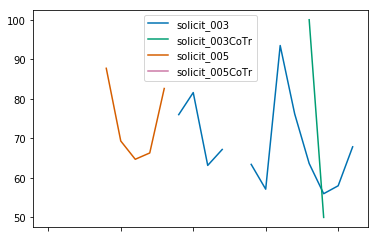

In [18]:
NtrialDB = pd.DataFrame(TTrialSplit, index=sessionSplit)
hitDB = pd.DataFrame(hitTargetSplit, index=sessionSplit)
hitDB = hitDB / NtrialDB *100

hitDB = hitDB.drop(columns= '')

hitDB.plot()



## Reaction time

In [19]:
allTrialsDF.columns

Index(['aborted', 'correction trial', 'gotReward', 'hit', 'lickL', 'lickR',
       'pokeL', 'pokeR', 'responseTime', 'stim', 'stim time', 'stimulus',
       'trialDuration', 'date', 'session nb'],
      dtype='object')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until


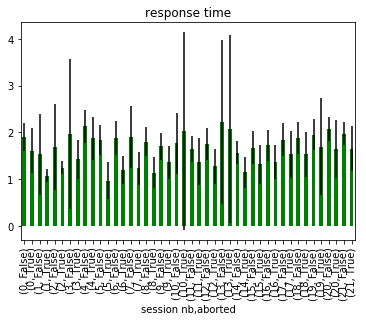

In [20]:
#allTrialsDF.boxplot(column='responseTime',by='date')
#allTrialsDF.plot.scatter ('session nb','responseTime')
avgRespTimes = allTrialsDF.groupby(("session nb","aborted")).agg([np.mean, np.std])
avgRespTimes = avgRespTimes['responseTime']
avgRespTimes.plot(kind = "bar", y = "mean", legend = False, 
          yerr = "std", title = "response time", color='green')



# Plot average response delay fct hit / miss / CT / aborted Global and over sessions
# 

In [21]:
avgRespTimes

mean       std
session nb aborted                    
0          False    1.897363  0.303022
           True     1.605105  0.482111
1          False    1.529673  0.860754
           True     1.068435  0.139434
2          False    1.687867  0.918743
           True     1.242745  0.143556
3          False    1.964220  1.606923
           True     1.421030  0.425822
4          False    2.133301  0.351924
           True     1.874594  0.464599
5          False    1.841906  0.325785
           True     0.969293  0.395319
6          False    1.882139  0.359331
           True     1.193756  0.297173
7          False    1.903824  0.665552
           True     1.231145  0.357564
8          False    1.800154  0.308214
           True     1.137829  0.329211
9          False    1.701405  0.293775
           True     1.360550  0.354949
10         False    1.763819  0.645581
           True     2.025052  2.113897
11         False    1.645195  0.269578
           True     1.371229  0.500884
12         False    1.749541  0.338083
           True     1.272144  0.376196
13         False    2.226476  1.756207
           True     2.077140  2.015610
14         False    1.564468  0.240858
           True     1.142907  0.328660
15         False    1.675515  0.348890
           True     1.314256  0.415269
16         False    1.723873  0.336440
           True     1.370475  0.357933
17         False    1.846454  0.343417
           True     1.526824  0.497632
18         False    1.887109  0.344520
           True     1.527252  0.472356
19         False    1.953458  0.323201
           True     1.697770  1.038626
20         False    2.075143  0.261677
           True     1.645970  0.615201
21         False    1.967399  0.247385
           True     1.654130  0.479053

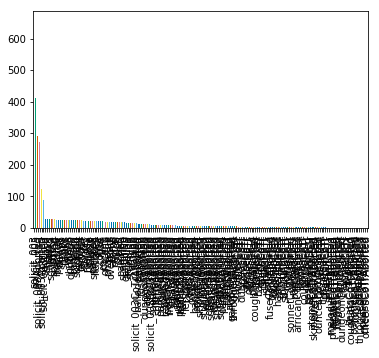

In [22]:
#allTrialsDF['stimulus'].plot.hist()
allTrialsDF['stimulus'].value_counts().plot(kind='bar')

In [23]:
sessionIdx = 19
trials = allGoodTrials[sessionIdx]
nHit = 0
nMiss = 0
rew_sides = list()
for trial in trials:
    if trial['aborted']:
        continue
    if trial['correction trial']:
        continue
    if trial['hit']:
        nHit = nHit + 1
    else:
        nMiss = nMiss + 1

    rew_sides.append(trial['stim'])
print(sessionSplit[sessionIdx])
print('n hit : ' + str(nHit))
print('n miss : ' + str(nMiss))
print('total trials : ' + str(len(allGoodTrials[sessionIdx])))
print('reward side : ' + str(sum(rew_sides)) + ' right - ' + str(len(rew_sides)) + ' trials - ' + str(round(sum(rew_sides)/len(rew_sides)*100)) + '%')

081021_116
n hit : 46
n miss : 24
total trials : 176
reward side : 39 right - 70 trials - 56.0%


In [24]:

# fig, ax = plt.subplots()
# N = 100

# scatter = ax.scatter(np.random.normal(size=N),
#                      np.random.normal(size=N),
#                      c=np.random.random(size=N),
#                      s=1000 * np.random.random(size=N),
#                      alpha=0.3,
#                      cmap=plt.cm.jet)
# ax.grid(color='white', linestyle='solid')

# ax.set_title("Scatter Plot (with tooltips!)", size=20)

# labels = ['point {0}'.format(i + 1) for i in range(N)]
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
# mpld3.plugins.connect(fig, tooltip)

# mpld3.show()

In [25]:
trial

{'stim': 0,
 'stim time': 1840.697,
 'hit': False,
 'correction trial': False,
 'aborted': True,
 'lickR': array([1844.091, 1844.142, 1844.227]),
 'lickL': array([], dtype=float64),
 'pokeR': array([1844.152]),
 'pokeL': array([], dtype=float64),
 'stimulus': 'solicit_003CoTrAborted',
 'gotReward': 'none',
 'trialDuration': 10,
 'responseTime': 3.4550000000001546}

## Bias (% response left)

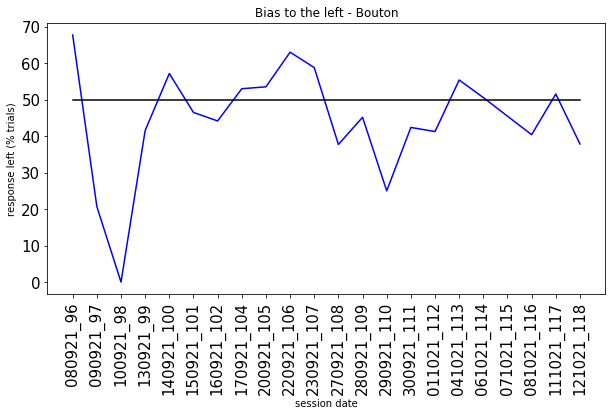

In [26]:
respL = list()
respR = list()
trialLength = list()
for trials in allTrials:
    nL = 0
    nR = 0
    for trial in trials:
        if trial[7]: # skip correction trials
            continue
        if trial[1] == 0:
            if trial[5]:
                nL = nL + 1
            else:
                nR = nR + 1
        else:
            if not trial[5]:
                nL = nL + 1
            else:
                nR = nR + 1
    respL.append(nL)
    respR.append(nR)
    trialLength.append(nL+nR)

rateL = 100 * np.array(respL) / np.array(trialLength)
rateR = 100 * np.array(respR) / np.array(trialLength)

plt.figure(figsize=figSize)
plt.plot(sessionSplit,rateL,color='b')
#plt.plot(sessionDate,missRate,color='b')
plt.plot(sessionSplit,[50]*len(sessionSplit),color='k')
plt.xlabel('session date')
plt.ylabel('response left (% trials)')
plt.title('Bias to the left - ' + animalName)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)

plt.show()